<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_09/05_a_xray_pneumonia_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import zipfile
import pathlib
import matplotlib.pyplot as plt

# Download dataset from Kaggle if not already done (or upload manually to Colab/Drive)
# Assuming you’ve manually uploaded and unzipped it in `/content/chest_xray/`
data_dir = pathlib.Path("/content/chest_xray")

train_dir = data_dir / "train"
val_dir = data_dir / "val"
test_dir = data_dir / "test"


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rutujapatil2","key":"824684e9eb529f96eb7d30f83bfdf6da"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!pip install -q kaggle

In [7]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


In [8]:
!unzip chest-xray-pneumonia.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0445-0001.jpeg  


In [9]:
import pathlib

data_dir = pathlib.Path("/content/chest_xray")
train_dir = data_dir / "train"
val_dir = data_dir / "val"
test_dir = data_dir / "test"

In [10]:
import tensorflow as tf

IMG_SIZE = (180, 180)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [12]:
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 5216 files belonging to 2 classes.
Using 4173 files for training.


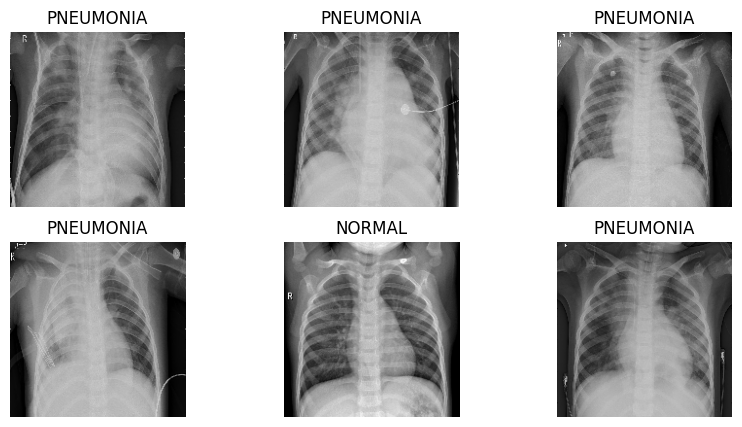

In [13]:
class_names = raw_train_ds.class_names

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for images, labels in raw_train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = raw_train_ds.prefetch(buffer_size=AUTOTUNE)

In [15]:
from tensorflow.keras import layers, models

def build_convnet(input_shape=(180, 180, 3), num_classes=2):
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),

        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes)
    ])
    return model

model = build_convnet()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,234 (25.36 MB)

 Trainable params: 6,647,234 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 395s 3s/step - accuracy: 0.7455 - loss: 0.6674 - val_accuracy: 0.9453 - val_loss: 0.1446
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 398s 3s/step - accuracy: 0.9346 - loss: 0.1780 - val_accuracy: 0.9578 - val_loss: 0.1376
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 383s 3s/step - accuracy: 0.9539 - loss: 0.1259 - val_accuracy: 0.9664 - val_loss: 0.1170
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 406s 3s/step - accuracy: 0.9638 - loss: 0.1037 - val_accuracy: 0.9607 - val_loss: 0.1478
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 385s 3s/step - accuracy: 0.9631 - loss: 0.0923 - val_accuracy: 0.9760 - val_loss: 0.0823
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 413s 3s/step - accuracy: 0.9755 - loss: 0.0628 - val_accuracy: 0.9712 - val_loss: 0.1090
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 384s 3s/step - accuracy: 0.9769 - loss: 0.0605 - val_accuracy: 0.9712 - val_loss: 0.0972
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 371s 3s/step - accuracy: 0.9856 - loss: 0.0510 - val_accu

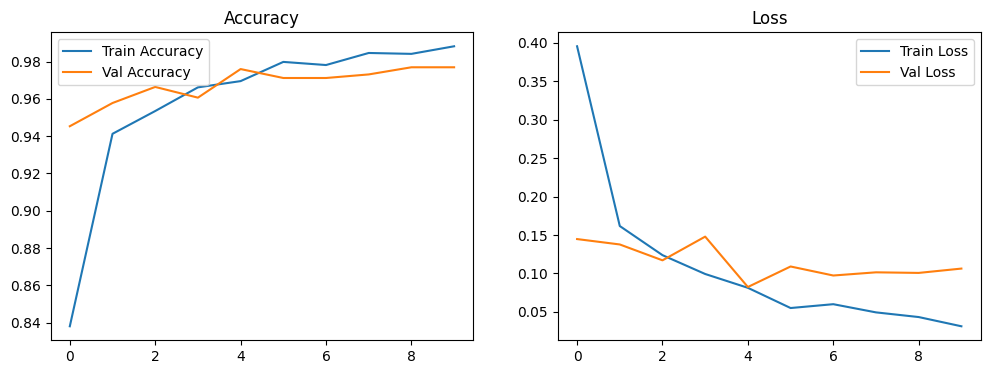

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [19]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2%}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 765ms/step - accuracy: 0.7343 - loss: 2.4005
Test Accuracy: 74.52%


In [20]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Model, layers

# Build model
def build_transfer_model(img_size=(180, 180, 3), num_classes=2):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=img_size)
    base_model.trainable = False  # Feature extraction mode

    inputs = layers.Input(shape=img_size)
    x = layers.Rescaling(1./255)(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes)(x)

    model = Model(inputs, outputs)
    return model

effnet_model = build_transfer_model()
effnet_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 6, 6, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [21]:
effnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history_effnet = effnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5  # You can increase this
)

Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.7277 - loss: 0.5925 - val_accuracy: 0.7613 - val_loss: 0.5548
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.7326 - loss: 0.5850 - val_accuracy: 0.7613 - val_loss: 0.5639
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.7320 - loss: 0.5861 - val_accuracy: 0.7613 - val_loss: 0.5504
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.7293 - loss: 0.5930 - val_accuracy: 0.7613 - val_loss: 0.5509
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 346s 3s/step - accuracy: 0.7334 - loss: 0.5911 - val_accuracy: 0.7613 - val_loss: 0.5559


In [22]:
# Unfreeze the top layers of the base model
effnet_model.layers[2].trainable = True  # base_model is the 3rd layer

# Recompile with lower LR
effnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Fine-tune
fine_tune_history = effnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 1110s 8s/step - accuracy: 0.4915 - loss: 0.7936 - val_accuracy: 0.7613 - val_loss: 0.6468
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 1175s 9s/step - accuracy: 0.8867 - loss: 0.3559 - val_accuracy: 0.5360 - val_loss: 0.6969
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 1048s 8s/step - accuracy: 0.9447 - loss: 0.2153 - val_accuracy: 0.5014 - val_loss: 0.7269
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 986s 7s/step - accuracy: 0.9491 - loss: 0.1692 - val_accuracy: 0.7344 - val_loss: 0.6318
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 937s 7s/step - accuracy: 0.9580 - loss: 0.1321 - val_accuracy: 0.7267 - val_loss: 0.5881


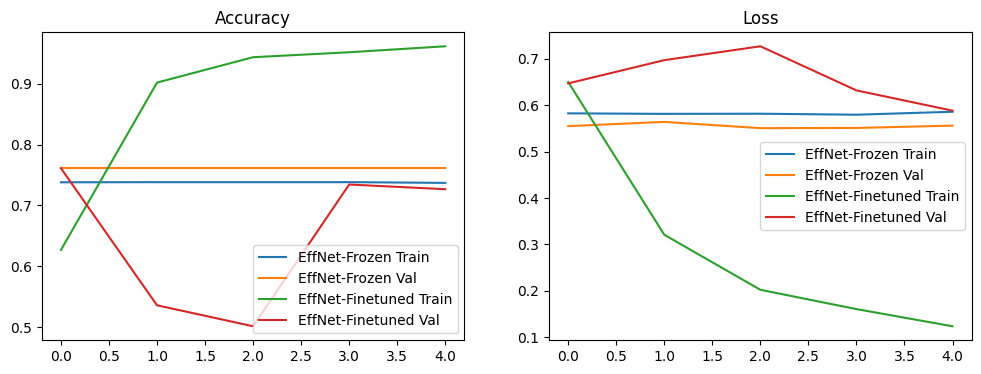

In [23]:
def plot_history(histories, labels):
    plt.figure(figsize=(12, 4))
    for i, label in enumerate(labels):
        acc = histories[i].history['accuracy']
        val_acc = histories[i].history['val_accuracy']
        plt.subplot(1, 2, 1)
        plt.plot(acc, label=f'{label} Train')
        plt.plot(val_acc, label=f'{label} Val')

    plt.title('Accuracy')
    plt.legend()

    for i, label in enumerate(labels):
        loss = histories[i].history['loss']
        val_loss = histories[i].history['val_loss']
        plt.subplot(1, 2, 2)
        plt.plot(loss, label=f'{label} Train')
        plt.plot(val_loss, label=f'{label} Val')

    plt.title('Loss')
    plt.legend()
    plt.show()

plot_history([history_effnet, fine_tune_history], ['EffNet-Frozen', 'EffNet-Finetuned'])


In [24]:
test_loss, test_acc = effnet_model.evaluate(test_ds)
print(f"Final Test Accuracy (Fine-tuned): {test_acc:.2%}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6544 - loss: 0.6838
Final Test Accuracy (Fine-tuned): 61.70%
